<a href="https://colab.research.google.com/github/AminPA/Matlab2020-10/blob/main/LevelSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("hello")

hello


In [2]:
pip install lsml

     |████████████████████████████████| 71kB 7.6MB/s 
     |████████████████████████████████| 419kB 12.5MB/s 
  Created wheel for scikit-fmm: filename=scikit_fmm-2021.2.2-cp37-cp37m-linux_x86_64.whl size=196599 sha256=39484b1a62b6cd16a13cdd8df39a234b0430f7757ced4a4e25369352bbdf1f19
  Stored in directory: /root/.cache/pip/wheels/86/5e/cb/4acf0bc71b46618ab7761d4b603227f29e56a3ec4ff2f64844
Successfully built scikit-fmm


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install pydicom
import pydicom
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
n_samples = 15
DATADIR = '/content/gdrive/MyDrive/Pittsbergh/TestPatientsForAmin/Patient11/ems11diastole/Images/'
# imgs = np.zeros((16,256,256))
#To read all the photos
imgs = []
import glob, os
os.chdir(DATADIR)
# i = 0
for file in glob.glob("*.IMA"):
  # imgs[i,:,:] = pydicom.read_file(file).pixel_array
  # i+=1
  imgs.append(pydicom.read_file(file).pixel_array)


imgs = np.array(imgs)
imgs = imgs.astype(float)


imgs.shape

# plt.imshow(imgs.pixel_array)
# plt.show()

(16, 256, 256)

In [ ]:
!pip install SimpleITK

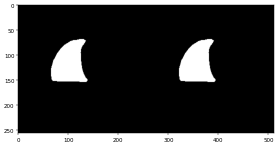

True hello


In [ ]:
import SimpleITK

def sitk_show(img, title=None, margin=0.0, dpi=40):
    nda = SimpleITK.GetArrayFromImage(img)
    # spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    # extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    extent = (0, nda.shape[1], nda.shape[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2 * margin, 1 - 2 * margin])
 
    plt.set_cmap("gray")
    ax.imshow(nda, extent=extent, interpolation=None)
 
    if title:
        plt.title(title)
 
    plt.show()

# Paths to the .mhd files
DATADIRS = '/content/gdrive/MyDrive/Pittsbergh/TestPatientsForAmin/Patient11/ems11diastole/Segmnetations.mha'

 
# Slice index to visualize with 'sitk_show'
idxSlice = 5
 
# int label to assign to the segmented gray matter
labelGrayMatter = 1
 
segs = SimpleITK.ReadImage(DATADIRS)

sitk_show(SimpleITK.Tile(segs[:, :, idxSlice],
                         segs[:, :, idxSlice],
                             (2, 1, 0)))
segs = SimpleITK.GetArrayFromImage(segs)

# segs = np.swapaxes(2,0,1)

segs = segs.astype(bool)

print(np.max(segs[5]),  'hello')

In [ ]:
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from lsml.data.dim2 import hamburger
from lsml import LevelSetMachineLearning
from lsml.feature import get_basic_image_features, get_basic_shape_features
from lsml.initializer import RandomBallInitializer


random_state = np.random.RandomState(1234)


# Create a toy dataset ########################################################

n_samples = 200
imgs1, segs1 = hamburger.make_dataset(
    N=n_samples, random_state=random_state)
print(imgs1.shape, segs1.shape)
print(np.max(segs1[5]))


n_samples = 16

# Set up the model and fit it #################################################

lsml = LevelSetMachineLearning(
    features=get_basic_image_features() + get_basic_shape_features(),
    initializer=RandomBallInitializer(random_state=random_state)
)

lsml.fit(
    'dataset2.h5', imgs=imgs, segs=segs,
    max_iters=10, random_state=random_state,

    # We use a sklearn Pipeline as the regression model which is
    # simply a standard scaler followed by linear regression
    regression_model_class=Pipeline,
    regression_model_kwargs=dict(
        steps=[
            ('standardscaler', StandardScaler()),
            ('linearregressor', LinearRegression()),
        ],
     )
)

ValueError: ignored

In [ ]:
from lsml import LevelSetMachineLearning
from lsml.visualize import interactive2d


# Load the model and grab an example from the testing set
model = LevelSetMachineLearning.load('./LSML-model.pkl')
example = model.testing_data[0]

# Segment the example image
us = model.segment(img=example.img)

# View the example interactively
interactive2d(u=us, img=example.img, seg=example.seg)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import ImageMagickWriter

from lsml import LevelSetMachineLearning
from lsml.visualize import plot_iso_contours


# Load the model and an example
model = LevelSetMachineLearning.load('./LSML-model.pkl')
example = model.testing_data[13]


# Set up plotting for the movie frames
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.axis('off')
ax.imshow(example.img, cmap=plt.cm.gray, interpolation='bilinear')
lines = []


# Set up the movie writer and grab the frame at initialization
writer = ImageMagickWriter(fps=5)
writer.setup(fig, 'evolution.gif', 100)
writer.grab_frame()


# Define the callback function to be used during segmentation evolution
def update_movie(i, u):

    if i % 10 != 0:
        return

    for line in lines:
        line.remove()
    lines.clear()

    lines.extend(
        plot_iso_contours(ax, u, value=0, c='b')
    )
    ax.set_title("Iteration: {:d}".format(i))

    writer.grab_frame()


us = model.segment(img=example.img, on_iterate=[update_movie], verbose=True)

# Close out the movie writing
writer.finish()